In [34]:
from langgraph.graph import StateGraph,START,END
from langchain_google_genai import ChatGoogleGenerativeAI
from typing import TypedDict,Annotated
from pydantic import BaseModel,Field
import operator
from IPython.display import Image
from dotenv import load_dotenv
load_dotenv()

True

In [24]:
class EvaluationSchema(BaseModel):
    feedback:str=Field(description='Detailed feedback of the essay')
    score:int=Field(description='Score out of 10',ge=0,le=10)

In [25]:
model=ChatGoogleGenerativeAI(model='gemini-2.5-pro',temperature=0.2)
structured_model=model.with_structured_output(EvaluationSchema)

In [26]:
essay="""Introduction
“A nation's greatness persists not in its power over people, but in its power over ideas.” The 21st century heralds a shift—not toward territorial dominion, but intellectual influence. “The empires of the future will be the empires of the mind,” observed Winston Churchill, more prescient than prophetic. In an age of digital connectivity, artificial intelligence, and global knowledge flows, the might of armies is being overshadowed by the power of innovation, culture, and ideas.

Body Paragraph - Defining Mind-Based Empires
Historically, empires thrived by expanding their borders, controlling resources, and imposing governance systems. In contrast, mind-based empires derive influence not through coercion, but through persuasion. They shape thought processes, dictate narratives, and set benchmarks in technology, science, art, and governance. The reach of Google's search engine, Netflix's cultural productions, or Oxford's academic credibility is far more enduring than any military conquest.

Body Paragraph - India's Opportunity
India stands at a unique juncture. With its demographic dividend, thriving IT sector, and millennia-old cultural heritage, it possesses the raw material for building a mind-based empire. Initiatives like Digital India, Startup India, and the National Education Policy aim to harness this potential. However, to translate these into global influence, India must bridge the digital divide, nurture critical thinking, and promote its cultural narratives beyond mere symbolism.

Conclusion
In the emerging global order, the contest is not for territory, but for mindshare. Nations that can innovate, educate, and inspire will dominate. For India, the challenge lies in moving beyond being a service provider to becoming a thought leader. If we invest in the intellectual empowerment of our citizens and amplify our cultural and technological presence, we can indeed shape an empire of the mind—an empire built not on conquest, but on ideas."""

In [38]:
class UPSCState(TypedDict):
    essay:str
    coa_feedback:str
    doa_feedback:str
    lang_feedback:str
    overall_feedback:str
    scores:Annotated[list[int],operator.add]
    avg_score:float

In [39]:
def coa(state:UPSCState)->UPSCState:
    prompt=f'Evaluate the clarity of thought of the following essay and provide a feedback and assign a score out of 10\n {state['essay']}'
    results=structured_model.invoke(prompt)
    return {'coa_feedback':results.feedback , 'scores':[results.score]}

def doa(state:UPSCState)->UPSCState:
    prompt=f'Evaluate the depth of analysis of the following essay and provide a feedback and assign a score out of 10\n {state['essay']}'
    results=structured_model.invoke(prompt)
    return {'doa_feedback':results.feedback , 'scores':[results.score]}

def language(state:UPSCState)->UPSCState:
    prompt=f'Evaluate the language quality of the following essay and provide a feedback and assign a score out of 10\n {state['essay']}'
    results=structured_model.invoke(prompt)
    return {'lang_feedback':results.feedback , 'scores':[results.score]}

def final_evaluation(state:UPSCState)->UPSCState:
    prompt=f"""Evaluate on the following feedbacks create a summarized feedback \n language feedback: - {state['lang_feedback']} \n clarity of thought feedback : {state['coa_feedback']} \n depth of analysis feedback: {state['doa_feedback']} """
    results=model.invoke(prompt)
    return {'overall_feedback':results.content, 'avg_score':sum(state['scores'])/len(state['scores'])}

In [40]:
graph=StateGraph(UPSCState)
graph.add_node('coa',coa)
graph.add_node('doa',doa)
graph.add_node('language',language)
graph.add_node('final_evaluation',final_evaluation)

graph.add_edge(START,'coa')
graph.add_edge(START,'doa')
graph.add_edge(START,'language')

graph.add_edge('coa','final_evaluation')
graph.add_edge('doa','final_evaluation')
graph.add_edge('language','final_evaluation')

graph.add_edge('final_evaluation',END)

workflow=graph.compile()

In [42]:
results=workflow.invoke({'essay':essay})
results

{'essay': "Introduction\n“A nation's greatness persists not in its power over people, but in its power over ideas.” The 21st century heralds a shift—not toward territorial dominion, but intellectual influence. “The empires of the future will be the empires of the mind,” observed Winston Churchill, more prescient than prophetic. In an age of digital connectivity, artificial intelligence, and global knowledge flows, the might of armies is being overshadowed by the power of innovation, culture, and ideas.\n\nBody Paragraph - Defining Mind-Based Empires\nHistorically, empires thrived by expanding their borders, controlling resources, and imposing governance systems. In contrast, mind-based empires derive influence not through coercion, but through persuasion. They shape thought processes, dictate narratives, and set benchmarks in technology, science, art, and governance. The reach of Google's search engine, Netflix's cultural productions, or Oxford's academic credibility is far more enduri

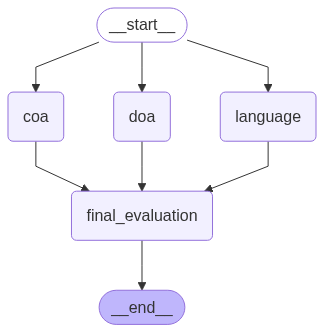

In [41]:
Image(workflow.get_graph().draw_mermaid_png())